In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from IPython.display import Image

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [4]:
DATASET_PATH = '/Users/daralobzova/Downloads/project_data_from_kaggle/train.csv'
PREPARED_DATASET_PATH = '/Users/daralobzova/Downloads/project_data_from_kaggle/test.csv' 

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [6]:
df = pd.read_csv(DATASET_PATH, sep=',')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [7]:
df.shape

(10000, 20)

In [8]:
df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

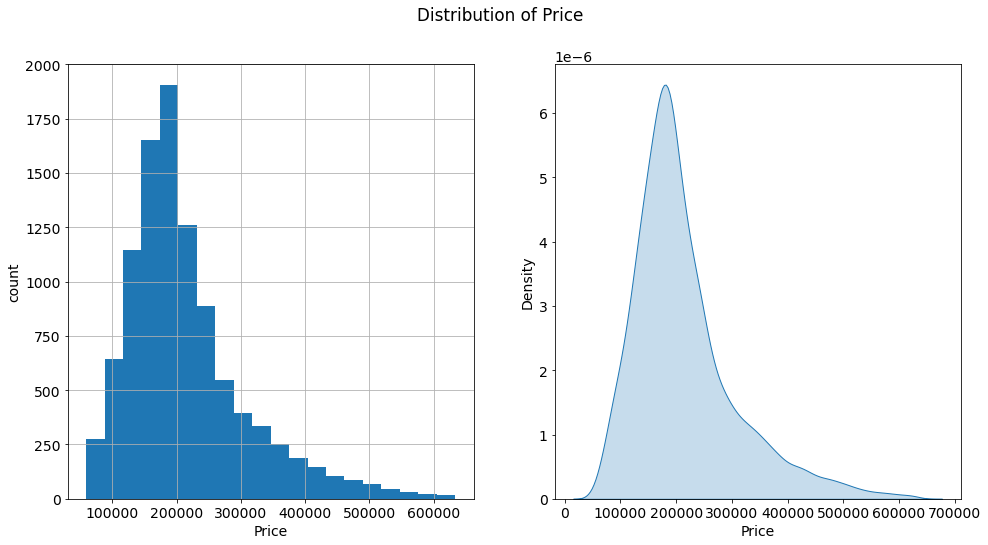

In [9]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [10]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

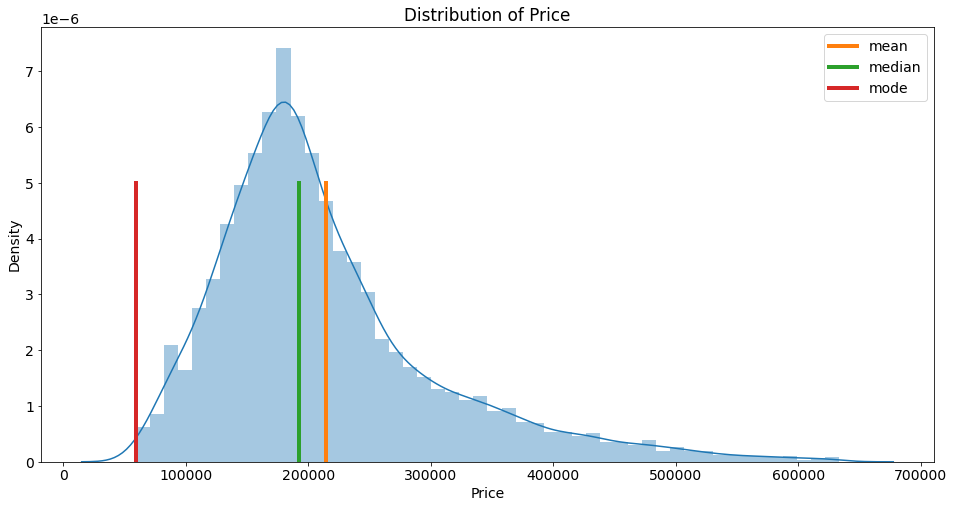

In [11]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

выкинем странные значения из выборки

In [12]:
target_bins = df['Price'] // 10000 * 10000
# 0 - 10000 --> 0
# 10001 - 20000 --> 1
# ...

target_adjusted_mode = target_bins.mode()[0]

target_adjusted_mode

180000.0

In [13]:
df['Price'].value_counts()

305018.871089    1
250690.485361    1
109180.930270    1
190451.552519    1
268723.157677    1
                ..
282595.048212    1
174164.867390    1
345232.282316    1
162953.431516    1
177685.627486    1
Name: Price, Length: 10000, dtype: int64

In [14]:
target_bins

0       300000.0
1       170000.0
2       280000.0
3       160000.0
4       340000.0
          ...   
9995    110000.0
9996    190000.0
9997    160000.0
9998    170000.0
9999    170000.0
Name: Price, Length: 10000, dtype: float64

In [15]:
target_bins.value_counts().iloc[:10]

180000.0    740
170000.0    673
160000.0    614
190000.0    596
150000.0    543
200000.0    517
140000.0    495
210000.0    469
130000.0    435
220000.0    373
Name: Price, dtype: int64

In [16]:
len(np.unique(target_bins))

59

In [17]:
np.unique(target_bins)

array([ 50000.,  60000.,  70000.,  80000.,  90000., 100000., 110000.,
       120000., 130000., 140000., 150000., 160000., 170000., 180000.,
       190000., 200000., 210000., 220000., 230000., 240000., 250000.,
       260000., 270000., 280000., 290000., 300000., 310000., 320000.,
       330000., 340000., 350000., 360000., 370000., 380000., 390000.,
       400000., 410000., 420000., 430000., 440000., 450000., 460000.,
       470000., 480000., 490000., 500000., 510000., 520000., 530000.,
       540000., 550000., 560000., 570000., 580000., 590000., 600000.,
       610000., 620000., 630000.])

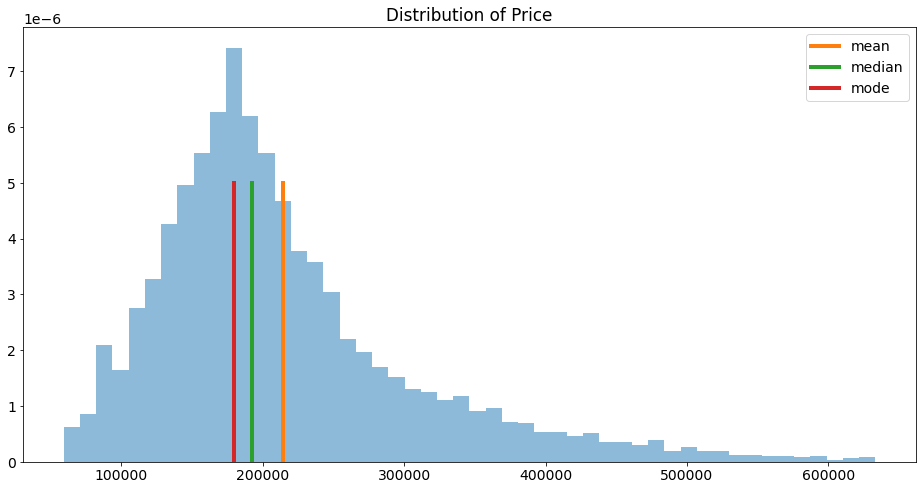

In [18]:
df = df[df['Price'] > 50000]

target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

plt.figure(figsize = (16, 8))
plt.hist(df['Price'], density=True, bins=50, alpha=0.5)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median', linewidth=4)
plt.plot([target_adjusted_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

### Анализ количественных признаков

In [19]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.drop('Price', axis=1, inplace=True)

In [20]:
df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6


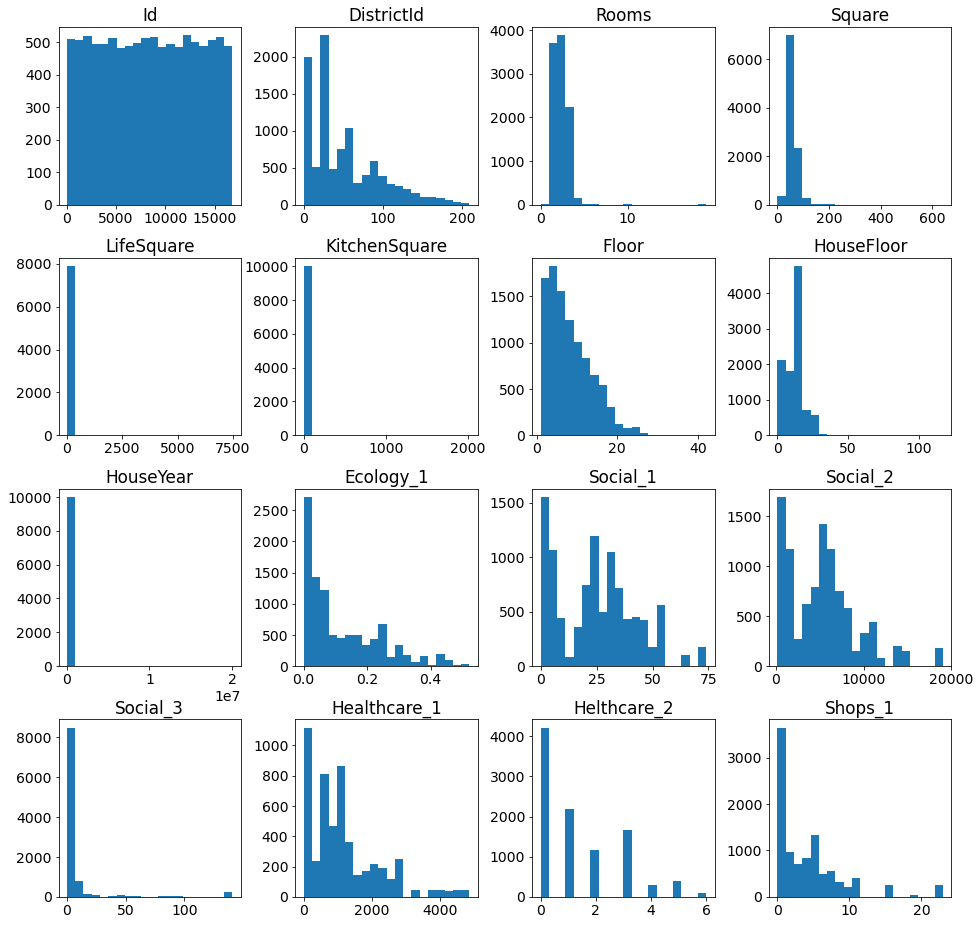

In [21]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False);

Id
DistrictId - Идентификационный номер района
Rooms - Комнаты
Square - Площадь
LifeSquare - Жильщная площадь 
KitchenSquare - Площадь кухни
Floor - Этаж
HouseFloor - Количество этажей в доме

In [22]:
df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999],
           dtype='int64', length=10000)

In [23]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### избавляемся от ненужных численных критериев

In [24]:
df['Id'] = df['Id'].astype(str)
df['Id'].dtype

dtype('O')

In [25]:
df['DistrictId'] = df['DistrictId'].astype(str)
df['DistrictId'].dtype

dtype('O')

In [26]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [27]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

### Уберем пропуски

создадим для Healthcare_1 новый столбец Healthcare_1_nan, чтобы знать, где были пропуски в таблице

In [28]:
df['Healthcare_1_nan'] = 0
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_nan
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,B,52,10311,6,NaN,1,9,B,119367.455796,0
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,199715.148807,0
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,B,20,4386,14,NaN,1,5,B,165953.912580,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,B,47,8004,3,125.0,3,5,B,171842.411855,0


In [29]:
df['Healthcare_1'].isna()

0        True
1       False
2       False
3        True
4        True
        ...  
9995     True
9996     True
9997     True
9998    False
9999     True
Name: Healthcare_1, Length: 10000, dtype: bool

In [30]:
df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1

In [31]:
df[df['Healthcare_1_nan'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_nan
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,1
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,1
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,160400.401732,1
11,16755,88,2.0,53.975144,34.153584,8.0,2,12.0,1978,0.127376,...,B,43,8429,3,NaN,3,9,B,253124.005332,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,9289,1,3.0,84.486078,88.931509,0.0,4,22.0,2016,0.007122,...,B,1,264,0,NaN,0,1,B,264213.558631,1
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,B,52,10311,6,NaN,1,9,B,119367.455796,1
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,199715.148807,1
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,B,20,4386,14,NaN,1,5,B,165953.912580,1


In [32]:
df['Healthcare_1_nan'].value_counts()

0    5202
1    4798
Name: Healthcare_1_nan, dtype: int64

меняем пропуски на медиану:

In [33]:
medians = df[['Healthcare_1']].median()
medians

Healthcare_1    900.0
dtype: float64

In [34]:
df[['Healthcare_1']] = df[['Healthcare_1']].fillna(medians)

In [35]:
df.isna().sum()

Id                     0
DistrictId             0
Rooms                  0
Square                 0
LifeSquare          2113
KitchenSquare          0
Floor                  0
HouseFloor             0
HouseYear              0
Ecology_1              0
Ecology_2              0
Ecology_3              0
Social_1               0
Social_2               0
Social_3               0
Healthcare_1           0
Helthcare_2            0
Shops_1                0
Shops_2                0
Price                  0
Healthcare_1_nan       0
dtype: int64

проверяем, есть ли какие-то пропуски в катигорийных критериях

In [36]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [37]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [38]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [39]:
df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [40]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Healthcare_1_nan
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.479800
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.499617
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,0.000000
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,1.000000
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000


### Проверяем данные на выбросы

рассмотрим количество комнат в квартире

In [41]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

т.к. в квартире не может быть 0 комнат, а 10 и 19 слишком большие значения, то это очевидно выбросы и мы их заменим. Поэтому для начала создадим столбец Rooms_outlier, в котором отметим строки, в которых делали замену

In [42]:
df['Rooms_outlier'] = 0
df.loc[(df['Rooms'] == 0) | (df['Rooms'] > 6), 'Rooms_outlier'] = 1
df[df['Rooms_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_nan,Rooms_outlier
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,74,19083,2,900.0,5,15,B,317265.323792,1,1
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,43,8429,3,900.0,3,9,B,158998.110646,1,1
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,...,25,5648,1,30.0,2,4,B,172329.270863,0,1
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,...,9,1892,0,900.0,0,1,B,98129.976788,1,1
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,...,30,6207,1,1183.0,1,0,B,217009.338463,0,1
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,1,264,0,900.0,0,1,B,78364.616704,1,1
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,...,9,1892,0,900.0,0,1,B,219281.918007,1,1
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,9,1892,0,900.0,0,1,B,302211.260887,1,1
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,...,5,1564,0,540.0,0,0,B,212864.799112,0,1
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,...,11,3097,0,900.0,0,0,B,268394.744389,1,1


In [43]:
df.loc[df['Rooms'] == 0, 'Rooms'] = 1
df.loc[df['Rooms'] > 6, 'Rooms'] = df['Rooms'].median()

In [44]:
df['Rooms'].value_counts()

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

In [45]:
df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [46]:
df['KitchenSquare'].quantile(.975), df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [47]:
df.loc[df['KitchenSquare'] < 3] = 3

comndition_KitchenSquare = (df['KitchenSquare'].isna()) \
    | (df['KitchenSquare'] > df['KitchenSquare'].quantile(.975)) 

df.loc[comndition_KitchenSquare, 'KitchenSquare'] = df['KitchenSquare'].median()

In [48]:
df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

In [49]:
df['KitchenSquare'].describe()

count    10000.000000
mean         6.238200
std          2.794717
min          3.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         13.000000
Name: KitchenSquare, dtype: float64

проанализируем этажность дома и на каком этаже нходится квартира

In [50]:
df['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 36., 37., 39., 40., 44., 45.,
       47., 48., 99.])

не может быть в доме 0 этажей, а так же верхняя граница самого высокого здания в Москве - 101 этаж, пометим себе, что на всякий случай нужно уберать возможные погрешности в этажах.

In [51]:
df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 42])

In [52]:
(df['Floor'] > df['HouseFloor']).sum()

852

т.к. у нас есть указания, что квартира находится на этаже выше, чем существует уже в доме, необходимо заменить эти данные

In [53]:
df['HouseFloor_outliner'] = 0
df.loc[df['HouseFloor'] == 0, 'HouseFloor_outliner'] = 1
df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outliner'] = 1

In [54]:
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()

In [55]:
floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
floor_outliers

Int64Index([  17,   21,   34,   39,  121,  124,  138,  141,  153,  154,
            ...
            9832, 9838, 9840, 9878, 9896, 9913, 9921, 9953, 9970, 9996],
           dtype='int64', length=844)

In [56]:
df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1,x))

In [57]:
(df['Floor'] > df['HouseFloor']).sum()

0

разберемся с годами постройки домов

In [58]:
df['HouseYear'].sort_values(ascending = False)

9163    20052011
8828        4968
2350        2020
1976        2020
9400        2020
          ...   
2410           3
6738           3
2408           3
2405           3
7085           3
Name: HouseYear, Length: 10000, dtype: int64

Самый старый жилой дом в москве был построен 350 лет назад, поэтому все года ранее необходимо убрать. Также сейчас у нас 2022 год, а значит года позже тоже необходимо заменить

In [59]:
df.loc[df['HouseYear'] > 2022, 'HouseYear'] = 2022
df.loc[df['HouseYear'] < 1672, 'HouseYear'] = df['HouseYear'].quantile(0.5)

In [60]:
df['HouseYear'].describe()

count    10000.000000
mean      1979.305600
std         16.719461
min       1910.000000
25%       1970.000000
50%       1970.000000
75%       1988.000000
max       2022.000000
Name: HouseYear, dtype: float64

посмотрим на площадь квартир

In [61]:
df['LifeSquare'].sort_values().unique()

array([  0.79553947,   1.62650211,   2.22859246, ..., 461.46361442,
       638.16319344,          nan])

In [62]:
df['Square'].sort_values().unique()

array([  3.        ,  13.78486476,  16.54724199, ..., 275.64528408,
       409.42518143, 641.06519275])

In [63]:
df['Square'].describe()

count    10000.000000
mean        38.248305
std         29.187786
min          3.000000
25%          3.000000
50%         41.358130
75%         56.992160
max        641.065193
Name: Square, dtype: float64

In [64]:
df['LifeSquare'].describe()

count    9864.000000
mean       24.246943
std        20.692119
min         0.795539
25%         3.000000
50%        22.886808
75%        34.872183
max       638.163193
Name: LifeSquare, dtype: float64

Самая маленькая квартира в Москве занимает 8.5 кв м., то будем считать, что все, что ниже этой отметки, приравнивается 8.5 , а слишком большие значения заменим на квантиль 97,5%

In [65]:
df['Square_outliner'] = 0
df.loc[(df['Square'] < 8.5) | (df['Square'] > df['Square'].quantile(.975)), 'Square_outliner'] = 1

In [66]:
df.loc[df['Square'] < 8.5, 'Square'] = 8.5
df.loc[df['Square'] > df['Square'].quantile(.975), 'Square'] = df['Square'].quantile(.975)

In [67]:
df['Square'].describe()

count    10000.000000
mean        39.437158
std         24.888480
min          8.500000
25%          8.500000
50%         41.358130
75%         56.992160
max         90.055648
Name: Square, dtype: float64

В столбце LifeSquare пропуски, их мы заменим на значение площади в этой квартире - площадь кухни - доп 3 кв метра

In [68]:
df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1

In [69]:
condition = (df['LifeSquare'].isna()) \
            &(~df['Square'].isna()) \
            &(~df['KitchenSquare'].isna())

In [70]:
df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] - df.loc[condition, 'KitchenSquare'] - 3

In [71]:
df['LifeSquare'].describe()

count    10000.000000
mean        24.551448
std         20.798093
min          0.795539
25%          3.000000
50%         23.149569
75%         35.293729
max        638.163193
Name: LifeSquare, dtype: float64

In [72]:
df['LifeSquare'].isna().sum()

0

тк жилищная площадь не может привышать площадь квартиры, то необходимо эти данные заменить

In [73]:
(df['LifeSquare'] >= df['Square']).sum()

151

In [74]:
df['LifeSquare_outliner'] = 0
df.loc[df['LifeSquare'] >= df['Square'], 'LifeSquare_outliner'] = 1

In [75]:
df.loc[df['LifeSquare'] >= df['Square'], 'LifeSquare'] = df['Square'] - 3

In [76]:
df['LifeSquare'].describe()

count    10000.000000
mean        24.234583
std         18.219636
min          0.795539
25%          3.000000
50%         23.149569
75%         35.123673
max         89.787666
Name: LifeSquare, dtype: float64

In [77]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_nan,Rooms_outlier,HouseFloor_outliner,Square_outliner,LifeSquare_nan,LifeSquare_outliner
0,11809,27,3.0,90.055648,77.055648,10.0,4,10.0,2014,0.075424,...,0,0,B,305018.871089,1,0,0,1,1,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,B,177734.553407,0,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,B,282078.720850,0,0,0,0,0,0
3,3,3,3.0,8.500000,3.000000,3.0,3,3.0,1970,3.000000,...,3,3,3,3.000000,3,3,0,1,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,B,343995.102962,1,0,0,0,0,0


In [78]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.HouseYear_quantile = None
        self.Square_quantile = None
    
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.HouseYear_quantile = X['HouseYear'].quantile(0.5)
        self.Square_quantile = X['Square'].quantile(.975)
        
    
    
    def transform(self, X):
        """Трансформация данных"""

        
        #Healthcare_1
        X['Healthcare_1_nan'] = 0
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = self.medians['Healthcare_1']
        
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition_KitchenSquare = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition_KitchenSquare, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        X.loc[X['HouseYear'] < 1672, 'HouseYear'] = self.HouseYear_quantile
        
        # Square
        X['Square_outliner'] = 0
        X.loc[(X['Square'] < 8.5) | (X['Square'] > self.Square_quantile), 'Square_outliner'] = 1
        
        X.loc[X['Square'] < 8.5, 'Square'] = 8.5
        X.loc[X['Square'] > self.Square_quantile, 'Square'] = self.Square_quantile
        
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        #LifeSquare_outliner
        X['LifeSquare_outliner'] = 0
        X.loc[X['LifeSquare'] >= X['Square'], 'LifeSquare_outliner'] = 1
        
        X.loc[X['LifeSquare'] >= X['Square'], 'LifeSquare'] = X['Square'] - 3
        
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

## Пострроение новых признаков

переводим все характеристики в численные данные

In [79]:
binary_to_numbers = {'A': 0, 'B': 1}

df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)

In [80]:
district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,3,3161
1,27,334
2,9,199
3,21,163
4,1,147


In [81]:
df = df.merge(district_size, on='DistrictId', how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Healthcare_1_nan,Rooms_outlier,HouseFloor_outliner,Square_outliner,LifeSquare_nan,LifeSquare_outliner,DistrictSize
0,11809,27,3.0,90.055648,77.055648,10.0,4,10.0,2014,0.075424,...,0,1,305018.871089,1,0,0,1,1,0,334
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,1,177734.553407,0,0,0,0,0,0,38
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,1,282078.720850,0,0,0,0,0,0,147
3,3,3,3.0,8.500000,3.000000,3.0,3,3.0,1970,3.000000,...,3,3,3.000000,3,3,0,1,0,0,3161
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,1,343995.102962,1,0,0,0,0,0,80


разложим районы на большие и маленькие

In [82]:
(df['DistrictSize'] > 100).value_counts()

False    5163
True     4837
Name: DistrictSize, dtype: int64

In [83]:
df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int)

сделаем категории для критериев Floor & HouseYear

In [84]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X

def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X

Добавляем эти категории в нашу табличку

In [85]:
df = year_to_cat(df)
df = floor_to_cat(df)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1_nan,Rooms_outlier,HouseFloor_outliner,Square_outliner,LifeSquare_nan,LifeSquare_outliner,DistrictSize,IsDistrictLarge,year_cat,floor_cat
0,11809,27,3.0,90.055648,77.055648,10.0,4,10.0,2014,0.075424,...,1,0,0,1,1,0,334,1,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,0,38,0,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0,0,147,1,4,1
3,3,3,3.0,8.500000,3.000000,3.0,3,3.0,1970,3.000000,...,3,3,0,1,0,0,3161,1,3,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,0,0,0,0,0,80,0,3,5


На основе этих данных найдем среднюю цену по этим критериям

In [86]:
med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,374737.658654
1,1,2,329090.758590
2,1,3,362698.813373
3,1,4,274992.472366
4,2,1,467230.539057


добавим в таблицу получившиеся данные

In [87]:
df = df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outliner,Square_outliner,LifeSquare_nan,LifeSquare_outliner,DistrictSize,IsDistrictLarge,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,90.055648,77.055648,10.0,4,10.0,2014,0.075424,...,0,0,1,1,0,334,1,6,2,164803.070010
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,38,0,3,3,205578.673632
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0,147,1,4,1,202046.143358
3,3,3,3.0,8.500000,3.000000,3.0,3,3.0,1970,3.000000,...,3,0,1,0,0,3161,1,3,1,3.000000
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,0,0,80,0,3,5,217739.570272


In [88]:
med_price_by_floor_year[(med_price_by_floor_year.year_cat == 6) & (med_price_by_floor_year.floor_cat == 2)]

,year_cat,floor_cat,MedPriceByFloorYear
22,6,2,164803.07001


In [89]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
    
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### Отбор признаков

In [90]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize', 
                     'IsDistrictLarge', 'MedPriceByFloorYear']

target_name = 'Price'

In [91]:
train_df = pd.read_csv(DATASET_PATH)
test_df = pd.read_csv(PREPARED_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [92]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [93]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 26), (3300, 26), (5000, 26))

In [94]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 32), (3300, 32), (5000, 32))

In [95]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [96]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

## Построение модели

Обучение

In [97]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

Оценка модели

Train R2:	0.961
Test R2:	0.748


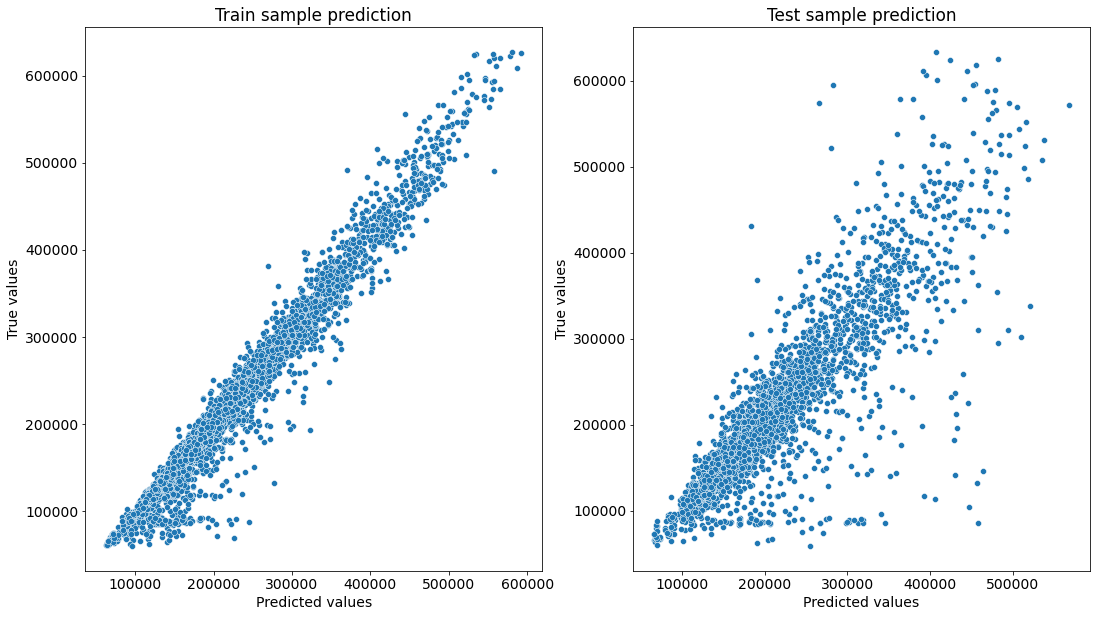

In [98]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Кросс-валидация. Если данные будут почти схожи, то модель хорошая

In [99]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.414245
20,DistrictSize,0.221243
12,Social_3,0.054473
2,LifeSquare,0.037198
7,Ecology_1,0.034689
11,Social_2,0.032632
6,HouseYear,0.030727
22,MedPriceByFloorYear,0.030126
0,Rooms,0.028508
10,Social_1,0.025658


Train R2:	0.84
Test R2:	0.748


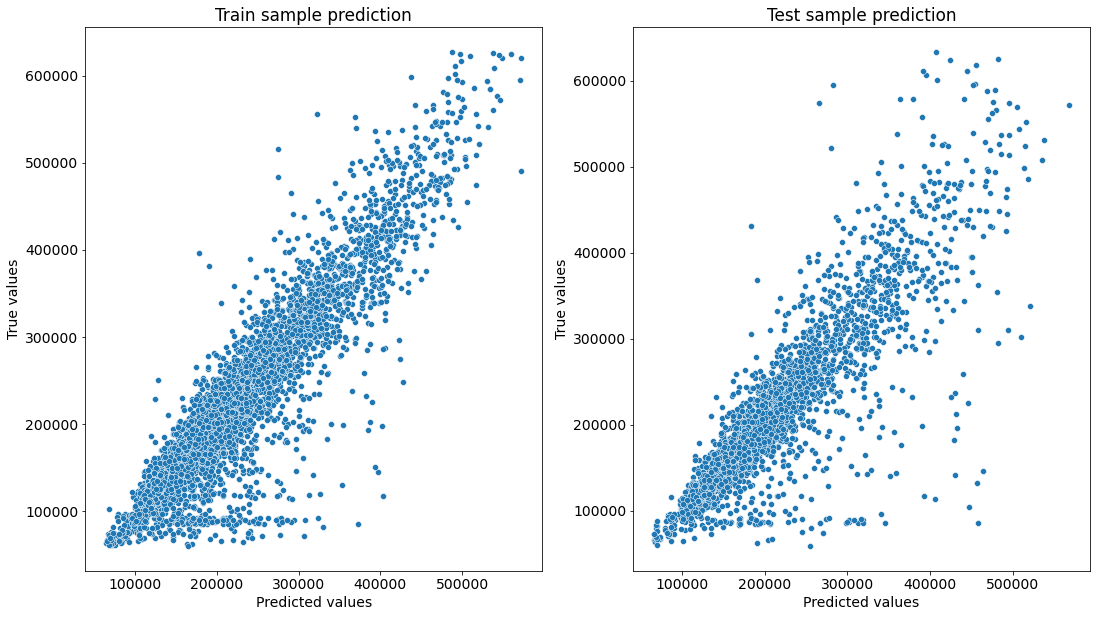

In [101]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=10,
                                     random_state=21,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [102]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.73271759, 0.70471183, 0.72301089])

In [103]:
cv_score.mean()

0.720146769435526

In [104]:
test_df.shape

(5000, 23)

In [105]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,1,1,1,0,0,0,0,76.0,0,189535.238131
1,1.0,42.493907,39.493907,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,0,0,164.0,1,177710.601401
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,0,1,1,0,0,0,1,580.0,1,174137.278013
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,0,1,0,0,0,0,372.0,1,180452.272989
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,...,0,6,1,0,0,0,1,65.0,0,192658.547447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,2,5.0,1962,0.069660,1,1,...,1,2,1,0,1,0,0,56.0,0,180452.272989
4996,3.0,93.698122,90.698122,10.0,21,27.0,2018,0.060753,1,1,...,0,7,1,0,0,0,0,26.0,0,198203.661141
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,2,5,1,0,0,0,0,54.0,0,180452.272989
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,0,11,1,0,0,0,0,40.0,0,192658.547447


In [108]:
submit = pd.read_csv('/Users/daralobzova/Downloads/project_data_from_kaggle/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [110]:
predictions = gb_model.predict(test_df)
predictions

array([163441.28130127, 127400.85332078, 147718.36063142, ...,
       146488.97327328, 195402.08161144, 240248.64670257])

In [111]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163441.281301
1,5925,127400.853321
2,960,147718.360631
3,3848,128676.835628
4,746,209215.639649


In [113]:
submit.to_csv('gb_submit.csv', index=False)